In [1]:
import sys, os
sys.path.append("/home/daniil/repos/pytorch-segmentation-detection/")
sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import torch
from torchvision import transforms
import torchvision
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.layers import GlobalAvgPool2d

import numpy as np
import torch.nn as nn

from pytorch_segmentation_detection.datasets.cityscapes import Cityscapes

import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve,
                                                       RandomCropJoint,
                                                       Split2D)

from matplotlib import pyplot as plt
import numpy as np
import torch.optim as optim

from pytorch_segmentation_detection.metrics import RunningConfusionMatrix

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)


from pytorch_segmentation_detection.transforms import RandomCropJoint

number_of_classes = 19

labels = range(number_of_classes)

In [2]:

train_transform = ComposeJoint(
                [
                    RandomHorizontalFlipJoint(),
                    RandomCropJoint(crop_size=(224, 224)),
                    [transforms.ToTensor(), None],
                    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

trainset = Cityscapes('/home/daniil/projects/datasets/',
                      dataset_type=0,
                      joint_transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=4, drop_last=True)


valid_transform = ComposeJoint(
                [
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])


valset = Cityscapes('/home/daniil/projects/datasets/',
                    dataset_type=1,
                    joint_transform=valid_transform)


valset_loader = torch.utils.data.DataLoader(valset, batch_size=1,
                                            shuffle=False, num_workers=2)

train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(xrange(500))
train_subset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1,
                                                   sampler=train_subset_sampler,
                                                   num_workers=2)

# Define the validation function to track MIoU during the training
def validate():
    
    fcn.eval()
    
    running_confusion_matrix = RunningConfusionMatrix(labels=labels)
    
    for image, annotation in valset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)
        
        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled
        
        running_confusion_matrix.update_matrix(annotation_np, prediction_np)

    mean_intersection_over_union = running_confusion_matrix.compute_current_mean_intersection_over_union()
        
    fcn.train()

    return mean_intersection_over_union


def validate_train():
    
    fcn.eval()    
    running_confusion_matrix = RunningConfusionMatrix(labels=labels)
    
    for image, annotation in train_subset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)
        
        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()
        
        running_confusion_matrix.update_matrix(annotation_np, prediction_np)

    
    mean_intersection_over_union = running_confusion_matrix.compute_current_mean_intersection_over_union()
    
    fcn.train()

    return mean_intersection_over_union

<IPython.core.display.Javascript object>


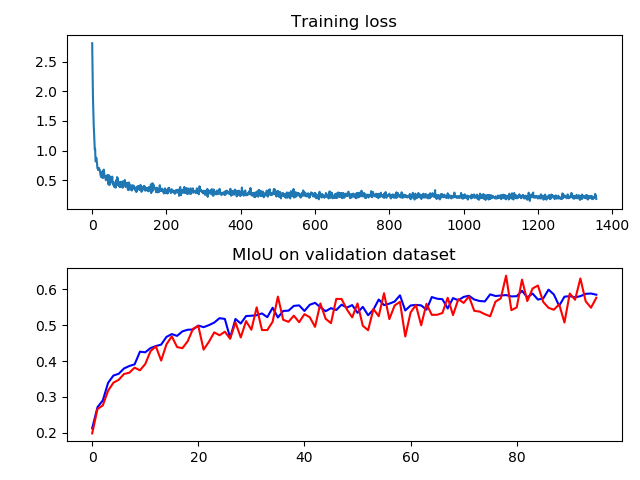

In [3]:
%matplotlib notebook

from matplotlib import pyplot as plt


# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []

train_validation_current_iteration = 0
train_validation_history = []
train_validation_iteration_number_history = []
 
f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
validation_axis.plot(validation_iteration_number_history, validation_history, 'b',
                     train_validation_iteration_number_history, train_validation_history, 'r')

loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')

plt.tight_layout()

In [4]:
## Define the model and load it to the gpu
fcn = resnet_dilated.Resnet18_8s(num_classes=19)
fcn.cuda()
fcn.train()

criterion = nn.CrossEntropyLoss(size_average=False).cuda()

optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


In [6]:
best_validation_score = 0

iter_size = 20

for epoch in range(130):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        img, anno = data
        
        # We need to flatten annotations and logits to apply index of valid
        # annotations. All of this is because pytorch doesn't have tf.gather_nd()
        anno_flatten = flatten_annotations(anno)
        index = get_valid_annotations_index(anno_flatten, mask_out_value=255)
        anno_flatten_valid = torch.index_select(anno_flatten, 0, index)

        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno_flatten_valid, index = Variable(img.cuda()), Variable(anno_flatten_valid.cuda()), Variable(index.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = fcn(img)
        logits_flatten = flatten_logits(logits, number_of_classes=19)
        logits_flatten_valid = torch.index_select(logits_flatten, 0, index)
        
        loss = criterion(logits_flatten_valid, anno_flatten_valid)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.data[0] / logits_flatten_valid.size(0)) 
        if i % 2 == 1:
            
            
            loss_history.append(running_loss / 2)
            loss_iteration_number_history.append(loss_current_iteration)
            
            loss_current_iteration += 1
            
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            running_loss = 0.0
            
        
            
    current_validation_score = validate()
    validation_history.append(current_validation_score)
    validation_iteration_number_history.append(validation_current_iteration)

    validation_current_iteration += 1

    validation_axis.lines[0].set_xdata(validation_iteration_number_history)
    validation_axis.lines[0].set_ydata(validation_history)



    current_train_validation_score = validate_train()
    train_validation_history.append(current_train_validation_score)
    train_validation_iteration_number_history.append(train_validation_current_iteration)

    train_validation_current_iteration += 1

    validation_axis.lines[1].set_xdata(train_validation_iteration_number_history)
    validation_axis.lines[1].set_ydata(train_validation_history)


    validation_axis.relim()
    validation_axis.autoscale_view()
    validation_axis.figure.canvas.draw()

    # Save the model if it has a better MIoU score.
    if current_validation_score > best_validation_score:

        torch.save(fcn.state_dict(), 'resnet_18_8s_cityscapes_best.pth')
        best_validation_score = current_validation_score
        print(best_validation_score)
        
                

print('Finished Training')

0.526442267824
0.527772768126
0.532877992422
0.548714072995
0.553847833012
0.555348808036
0.556986807907
0.562401367669
0.571601414
0.583259467715
0.586030565315
0.595849902277
0.599198361101


Process Process-773:
Process Process-774:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
    self._target(*self._args, **self._kwargs)
  File "/home/daniil/repos/pytorch-segmentation-detection/pytorch_segmentation_detection/datasets/cityscapes.py", line 81, in __getitem__
  File "/home/daniil/repos/anaconda2/lib/

KeyboardInterrupt: 